In [1]:
import igraph as ig
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from auxiliar_bb import apply_backboning
from auxiliar_projections_large import apply_projection
from auxiliar_optimization import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [9]:
### Select dataset
DATASET = "amz" # ["amz", "um", "am"]
PROJ_NAMES = ["simple", "vector", "jaccard", "neighs", "hyper", "resall"]

if DATASET == "um":
    FILENAME = "../12-third_year/00-Data/08-imdb/user-movie.graphml"
elif DATASET == "am":
    FILENAME = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/00-Data/05-actor-movie/actor-movie.graphml"
elif DATASET == "amz":
    FILENAME = "binet-AMZ-Rw.graphml"


### Load dataset

In [10]:
g = ig.read(FILENAME)
print(g.summary())
print()

top_nodes = g.vs.select(type=0)
bot_nodes = g.vs.select(type=1)

print("|U|=",len(top_nodes), " \t|R|=",len(bot_nodes), " \t|U|+|R|=",
      len(top_nodes)+len(bot_nodes), "=", g.vcount())
print()

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()


IGRAPH U-WT 17079 32769 -- 
+ attr: freq (v), id (v), type (v), weight (e)

|U|= 9561  	|R|= 7518  	|U|+|R|= 17079 = 17079

The graph IS bipartite


### Apply projection and backboning

In [11]:
for proj_opcion in PROJ_NAMES:
    ###### ****** Projections ****** ######
    top_graph = apply_projection(g, proj_opcion,
                                len(top_nodes), False) # False = Users = 0
    print("Done PROJ1 - Users Projection")
    edges_temp = top_graph.es()["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")

    bot_graph = apply_projection(g, proj_opcion,
                                len(top_nodes), True) # True = Resources = 1
    print("\nDone PROJ2 - Resources Projection")
    edges_temp = bot_graph.es()["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")
    print()

    ### Applying backboning
    for i, graph_type in enumerate([top_graph, bot_graph]):
        apply_backboning(graph_type, dataset=DATASET, proj_opcion=proj_opcion, nodetype=i, remove_zeros=False)
    

Done PROJ1 - Users Projection
Peso máximo=8 y mínimo=1 en aristas: 

Done PROJ2 - Resources Projection
Peso máximo=82 y mínimo=1 en aristas: 


##### **** BACKBONING USERS **** #####
Projection Name: simple
Summary
 IGRAPH U-WT 9561 1253277 -- 
+ attr: freq (v), id (v), type (v), weight (e)
##### END #####

Peso máximo=8 y mínimo=1 en aristas: 

Factor de escala: 1
Peso máximo=8 y mínimo=1 en aristas: 

TOP DF - time: 0.4112384319 seconds.
Grafo filtrado con alpha=0.05: IGRAPH U-WT 8345 1663 -- 
+ attr: freq (v), id (v), type (v), weight (e)
Grafo filtrado con alpha=0.1: IGRAPH U-WT 8691 9703 -- 
+ attr: freq (v), id (v), type (v), weight (e)
Grafo filtrado con alpha=0.15: IGRAPH U-WT 9408 29456 -- 
+ attr: freq (v), id (v), type (v), weight (e)
Grafo filtrado con alpha=0.2: IGRAPH U-WT 9408 74723 -- 
+ attr: freq (v), id (v), type (v), weight (e)
TOP NC - time: 0.7733087540 seconds.
Grafo filtrado con alpha=0.05: IGRAPH U-WT 9560 569794 -- 
+ attr: freq (v), id (v), type (v), weight (

## Top type 0 Optimization

In [12]:
NODETYPE = 0    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics

/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


{'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 1,
 'x9': 5.768845975594755,
 'x11': 3.8553228787812426}

In [13]:
# 2) Escanear carpeta de proyecciones
if NODETYPE == 0:
    proj_dir = DATASET+"/top"    
else:
    proj_dir = DATASET+"/bot" 
    
proj_files = [f for f in os.listdir(proj_dir) if f.endswith(".graphml")]


# 3) Calcular soluciones
solutions = []
to_df = []
names_df = []
k = 100 # For approximation

for fname in proj_files:
    gu = ig.Graph.Read_GraphML(os.path.join(proj_dir, fname))
    gu = remove_isolated_nodes(gu, k=1)

    # For approximation
    if k < gu.vcount():
        proj_metrics = compute_proj_metrics(gu,k)
    else:
        proj_metrics = compute_proj_metrics(gu,gu.vcount())
    
    
    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(fname[:-8])
    sol["filename"] = fname[:-8]
    
    if is_feasible(sol):
        solutions.append(sol)

### Creation of dataset    
a = pd.DataFrame(to_df)
b = pd.DataFrame(names_df)
a.columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
b.columns = ["name"]
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(proj_files))
print("Feasible solutions:", len(solutions))

All solutions: 48
Feasible solutions: 44


In [15]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")


Frente 1 (34 soluciones):

Frente 2 (10 soluciones):


In [16]:
cd = crowding_distance(all_fronts[0])
pareto_sorted = [s for _, s in sorted(zip(-cd, all_fronts[0]), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))

Crowding 34


### Plotting

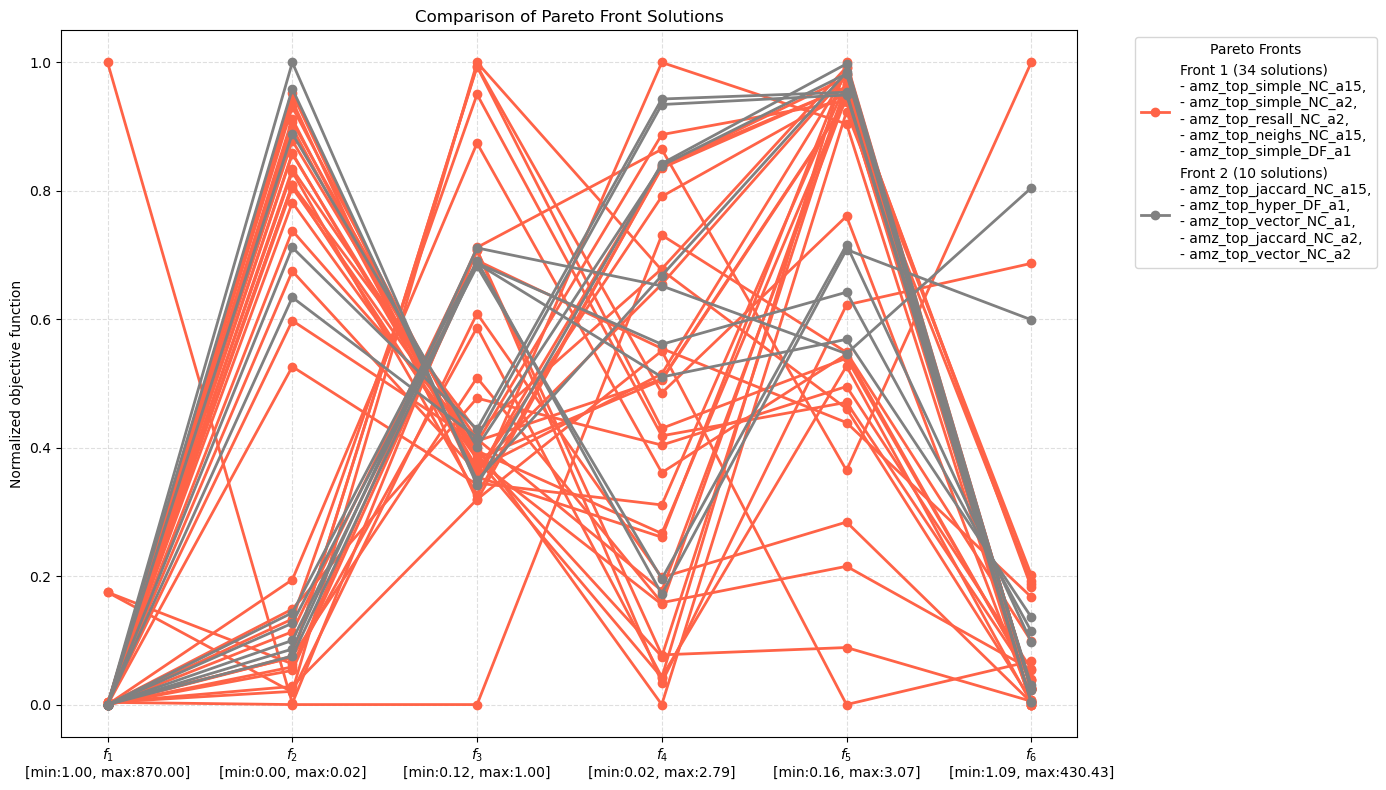

In [18]:
# --- Fin de la simulación de datos ---

labels = ["$f_1$", "$f_2$", "$f_3$", "$f_4$", "$f_5$", "$f_6$"]

# 1. Aplanar la lista de frentes para normalizar todos los datos juntos
todas_las_soluciones = [sol for front in all_fronts for sol in front]
F_all = np.array([sol["f"] for sol in todas_las_soluciones])

# 2. Calcular los valores mínimo y máximo de cada función objetivo
min_vals = F_all.min(axis=0)
max_vals = F_all.max(axis=0)

# 3. Normalizar todos los valores
F_norm_all = (F_all - min_vals) / (max_vals - min_vals + 1e-8)

# 4. Preparar la figura para la gráfica
plt.figure(figsize=(14, 8))

# Generar una escala de grises
num_frentes = len(all_fronts)
# Usar `np.linspace` para generar valores de gris desde un tono oscuro a uno claro.
# Por ejemplo, desde un gris 0.2 (oscuro) hasta 0.8 (claro).
gray_scale = np.linspace(0.2, 0.8, num_frentes+1)

# 5. Recorrer los frentes y las soluciones para graficar
idx_solucion = 0
for i, front in enumerate(all_fronts):
    rank = i + 1
    num_sols = len(front)

    # Asignar el color del frente
    if i == 0:
        color = "tomato"
    else:
        color = str(gray_scale[i])

    # Generar nombres de soluciones (puedes ajustar esto si tus soluciones tienen un identificador propio)
    nombres_soluciones = [sol.get("filename", f"sol_{idx_solucion + j}") for j, sol in enumerate(front)]
    nombres_mostrados = ",\n- ".join(nombres_soluciones[:5])
    
    # Etiqueta extendida para la leyenda
    label_front = f"Front {rank} ({num_sols} solutions)"
    if num_sols > 0:
        label_front += f"\n- {nombres_mostrados}"

    for j, sol in enumerate(front):
        F_norm_solucion = F_norm_all[idx_solucion]

        # Solo la primera solución del frente tiene leyenda
        if j == 0:
            label = label_front
        else:
            label = None

        plt.plot(
            labels,
            F_norm_solucion,
            color=color,
            linestyle='-',
            linewidth=2,
            marker='o',
            label=label
        )
        
        idx_solucion += 1


# 6. Actualizar las etiquetas del eje X con los rangos de valores reales
new_labels = [f"{lbl}\n[min:{min_v:.2f}, max:{max_v:.2f}]" for lbl, min_v, max_v in zip(labels, min_vals, max_vals)]
plt.xticks(range(len(new_labels)), new_labels, rotation=0)

# 7. Configurar y guardar la gráfica
plt.ylabel("Normalized objective function")
plt.title("Comparison of Pareto Front Solutions")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Pareto Fronts", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(DATASET+"-Type"+str(NODETYPE)+"-pf.png")
plt.show()


### Plotting Dimensinality Reduction

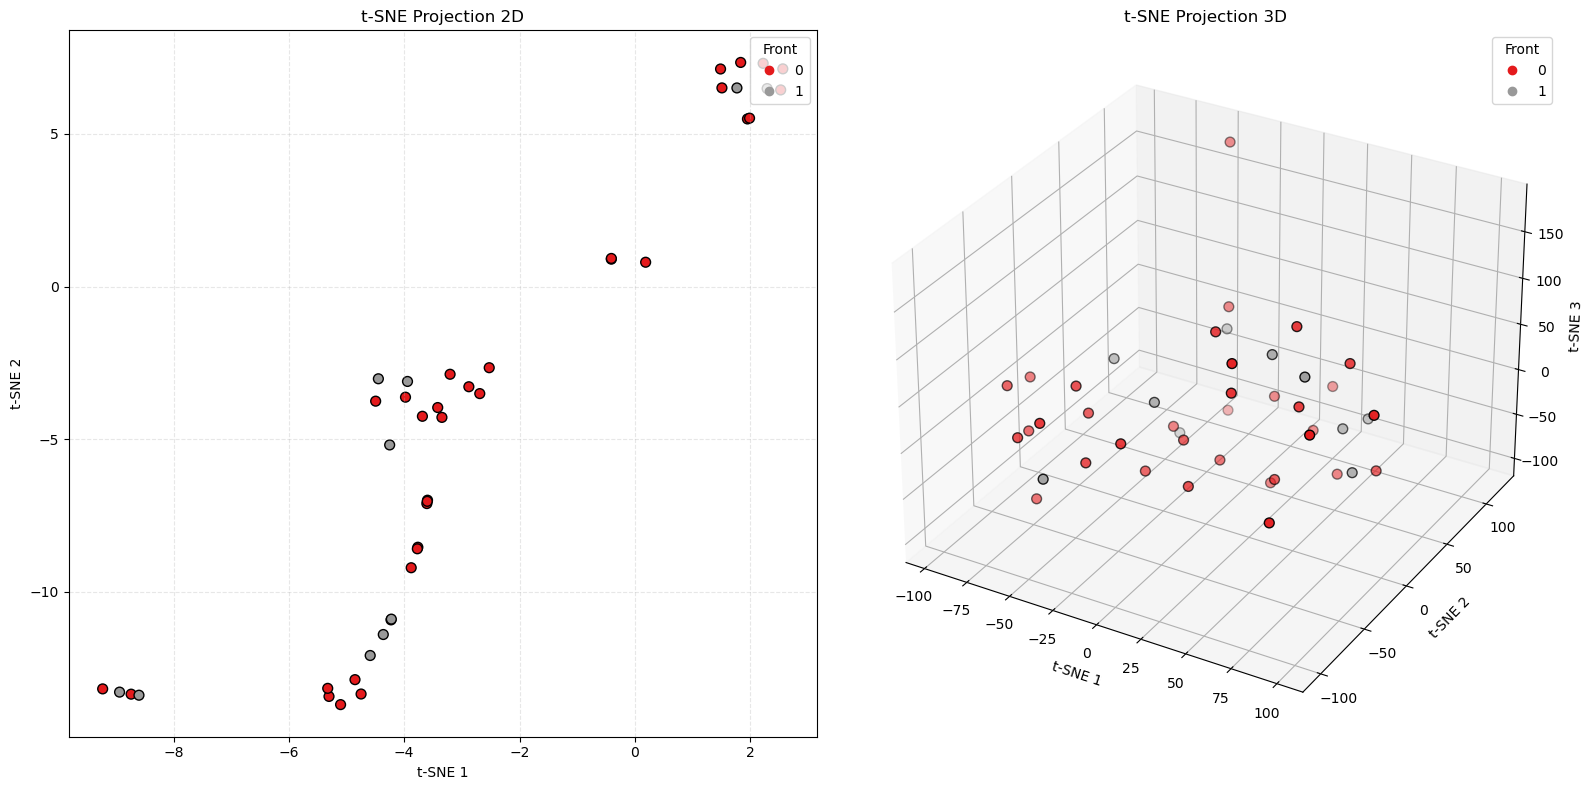

In [19]:
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)  # índice de frente

# Asegurarse de que los datos de entrada son arrays de NumPy
points = np.array(points)
labels = np.array(labels)

# Apply t-SNE
tsne_2d = TSNE(n_components=2, perplexity=10, random_state=42, init='pca', learning_rate='auto')
embedding_2d = tsne_2d.fit_transform(points)

tsne_3d = TSNE(n_components=3, perplexity=10, random_state=42, init='pca', learning_rate='auto')
embedding_3d = tsne_3d.fit_transform(points)

# Create subplots
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1) # 2D subplot

# Plot 2D
scatter_2d = ax1.scatter(embedding_2d[:, 0], embedding_2d[:, 1],
                         c=labels, cmap="Set1", s=50, edgecolors='k')
ax1.set_title("t-SNE Projection 2D")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax1.grid(True, linestyle="--", alpha=0.3)
ax1.legend(*scatter_2d.legend_elements(), title="Front", loc="upper right")

# Plot 3D
ax2 = fig.add_subplot(1, 2, 2, projection='3d') # 3D subplot
scatter_3d = ax2.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],
                         c=labels, cmap="Set1", s=50, edgecolors='k')
ax2.set_title("t-SNE Projection 3D")
ax2.set_xlabel("t-SNE 1")
ax2.set_ylabel("t-SNE 2")
ax2.set_zlabel("t-SNE 3")

# Ajustar diseño y guardar la figura
plt.tight_layout()
plt.savefig(DATASET+"-Type"+str(NODETYPE)+"-tsne.png")

ax2.legend(*scatter_3d.legend_elements(), title="Front", loc="upper right")


## Optimization type 0

In [20]:
NODETYPE = 1    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics

/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


{'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 1,
 'x9': 5.586364329636657,
 'x11': 2.154744528081951}

In [21]:
# 2) Escanear carpeta de proyecciones
if NODETYPE == 0:
    proj_dir = DATASET+"/top"    
else:
    proj_dir = DATASET+"/bot" 
    
proj_files = [f for f in os.listdir(proj_dir) if f.endswith(".graphml")]


# 3) Calcular soluciones
solutions = []
to_df = []
names_df = []
k = 100 # For approximation

for fname in proj_files:
    gu = ig.Graph.Read_GraphML(os.path.join(proj_dir, fname))
    gu = remove_isolated_nodes(gu, k=5)

    # For approximation
    if k < gu.vcount():
        proj_metrics = compute_proj_metrics(gu,k)
    else:
        proj_metrics = compute_proj_metrics(gu,gu.vcount())
    
    
    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(fname[:-8])
    sol["filename"] = fname[:-8]
    
    if is_feasible(sol):
        solutions.append(sol)

### Creation of dataset    
a = pd.DataFrame(to_df)
b = pd.DataFrame(names_df)
a.columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
b.columns = ["name"]
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(proj_files))
print("Feasible solutions:", len(solutions))

/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


All solutions: 48
Feasible solutions: 32


In [22]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")


Frente 1 (18 soluciones):

Frente 2 (10 soluciones):

Frente 3 (4 soluciones):


In [23]:
cd = crowding_distance(all_fronts[0])
pareto_sorted = [s for _, s in sorted(zip(-cd, all_fronts[0]), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))

Crowding 18


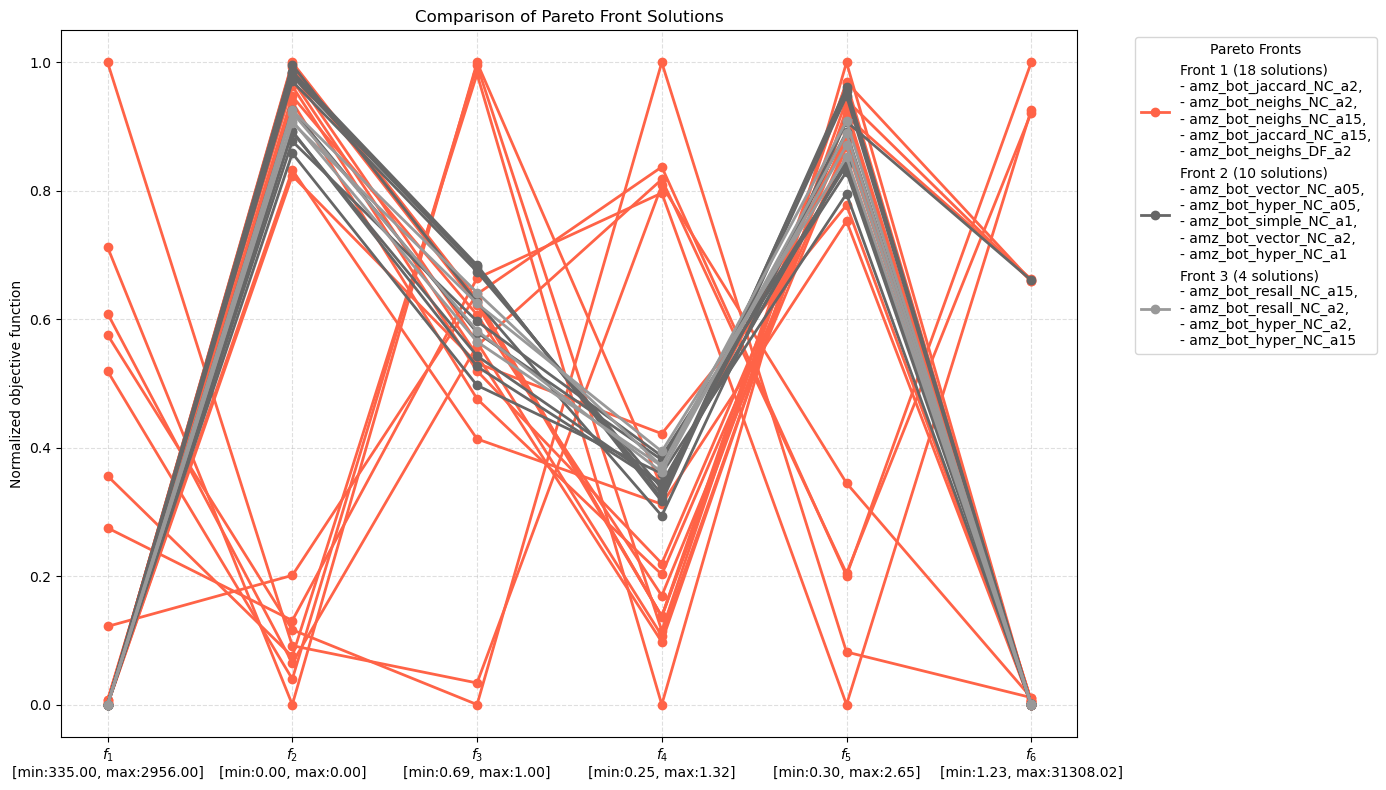

In [24]:
# --- Fin de la simulación de datos ---

labels = ["$f_1$", "$f_2$", "$f_3$", "$f_4$", "$f_5$", "$f_6$"]

# 1. Aplanar la lista de frentes para normalizar todos los datos juntos
todas_las_soluciones = [sol for front in all_fronts for sol in front]
F_all = np.array([sol["f"] for sol in todas_las_soluciones])

# 2. Calcular los valores mínimo y máximo de cada función objetivo
min_vals = F_all.min(axis=0)
max_vals = F_all.max(axis=0)

# 3. Normalizar todos los valores
F_norm_all = (F_all - min_vals) / (max_vals - min_vals + 1e-8)

# 4. Preparar la figura para la gráfica
plt.figure(figsize=(14, 8))

# Generar una escala de grises
num_frentes = len(all_fronts)
# Usar `np.linspace` para generar valores de gris desde un tono oscuro a uno claro.
# Por ejemplo, desde un gris 0.2 (oscuro) hasta 0.8 (claro).
gray_scale = np.linspace(0.2, 0.8, num_frentes+1)

used_colors = []

# 5. Recorrer los frentes y las soluciones para graficar
idx_solucion = 0
for i, front in enumerate(all_fronts):
    rank = i + 1
    num_sols = len(front)

    # Asignar el color del frente
    if i == 0:
        color = "tomato"   
    else:
        color = str(gray_scale[i])
    used_colors.append(color)

    # Generar nombres de soluciones (puedes ajustar esto si tus soluciones tienen un identificador propio)
    nombres_soluciones = [sol.get("filename", f"sol_{idx_solucion + j}") for j, sol in enumerate(front)]
    nombres_mostrados = ",\n- ".join(nombres_soluciones[:5])
    
    # Etiqueta extendida para la leyenda
    label_front = f"Front {rank} ({num_sols} solutions)"
    if num_sols > 0:
        label_front += f"\n- {nombres_mostrados}"

    for j, sol in enumerate(front):
        F_norm_solucion = F_norm_all[idx_solucion]

        # Solo la primera solución del frente tiene leyenda
        if j == 0:
            label = label_front
        else:
            label = None

        plt.plot(
            labels,
            F_norm_solucion,
            color=color,
            linestyle='-',
            linewidth=2,
            marker='o',
            label=label
        )
        
        idx_solucion += 1


# 6. Actualizar las etiquetas del eje X con los rangos de valores reales
new_labels = [f"{lbl}\n[min:{min_v:.2f}, max:{max_v:.2f}]" for lbl, min_v, max_v in zip(labels, min_vals, max_vals)]
plt.xticks(range(len(new_labels)), new_labels, rotation=0)

# 7. Configurar y guardar la gráfica
plt.ylabel("Normalized objective function")
plt.title("Comparison of Pareto Front Solutions")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Pareto Fronts", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(DATASET+"-Type"+str(NODETYPE)+"-pf.png")
plt.show()


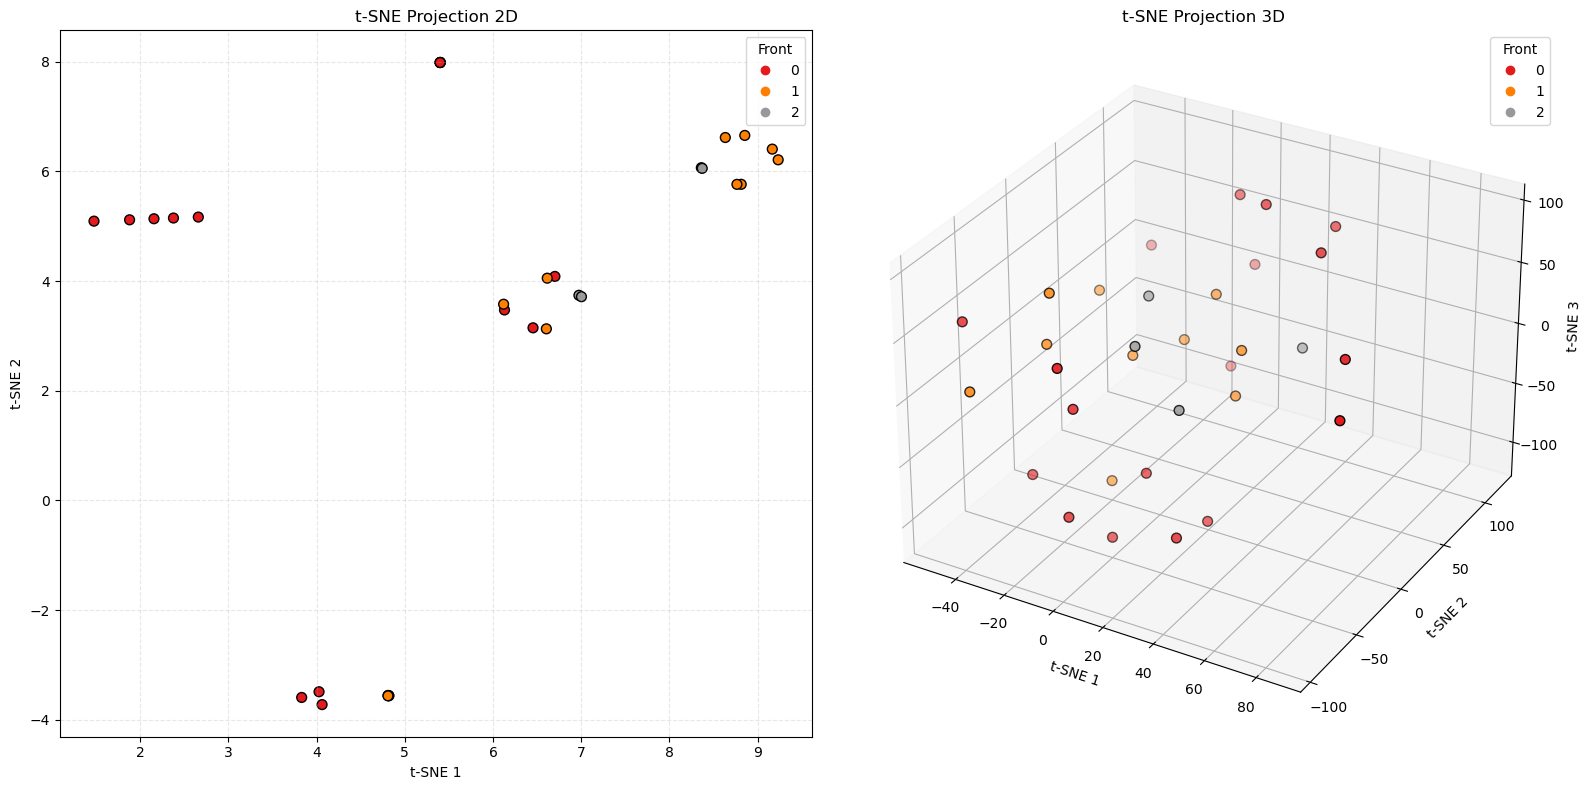

In [25]:
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)  # índice de frente

# Asegurarse de que los datos de entrada son arrays de NumPy
points = np.array(points)
labels = np.array(labels)

# Apply t-SNE
tsne_2d = TSNE(n_components=2, perplexity=10, random_state=42, init='pca', learning_rate='auto')
embedding_2d = tsne_2d.fit_transform(points)

tsne_3d = TSNE(n_components=3, perplexity=10, random_state=42, init='pca', learning_rate='auto')
embedding_3d = tsne_3d.fit_transform(points)

# Create subplots
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1) # 2D subplot

# Plot 2D
scatter_2d = ax1.scatter(embedding_2d[:, 0], embedding_2d[:, 1],
                         c=labels, cmap="Set1", s=50, edgecolors='k')
ax1.set_title("t-SNE Projection 2D")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax1.grid(True, linestyle="--", alpha=0.3)
ax1.legend(*scatter_2d.legend_elements(), title="Front", loc="upper right")

# Plot 3D
ax2 = fig.add_subplot(1, 2, 2, projection='3d') # 3D subplot
scatter_3d = ax2.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],
                         c=labels, cmap="Set1", s=50, edgecolors='k')
ax2.set_title("t-SNE Projection 3D")
ax2.set_xlabel("t-SNE 1")
ax2.set_ylabel("t-SNE 2")
ax2.set_zlabel("t-SNE 3")
ax2.legend(*scatter_3d.legend_elements(), title="Front", loc="upper right")

# Ajustar diseño y guardar la figura
plt.tight_layout()
plt.savefig(DATASET+"-Type"+str(NODETYPE)+"-tsne.png")

FIN